<a href="https://colab.research.google.com/github/LeoDinga/DL_Project/blob/main/Project_DL_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!git clone --filter=blob:none --no-checkout https://github.com/THETIS-dataset/dataset.git
%cd dataset
!git sparse-checkout init --cone
!git sparse-checkout set VIDEO_Skelet3D
!git checkout

fatal: destination path 'dataset' already exists and is not an empty directory.
/content/dataset
Your branch is up to date with 'origin/main'.


Run this only the first time


In [2]:
!pip uninstall -y mediapipe-silicon
!pip uninstall -y mediapipe
!pip uninstall -y protobuf
!pip install protobuf==3.20.3  # Specific version that often works well with MediaPipe
!pip install mediapipe


Found existing installation: protobuf 5.29.4
Uninstalling protobuf-5.29.4:
  Successfully uninstalled protobuf-5.29.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 9.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 29.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.7 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
grpcio

In [3]:
import os
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import torchvision.models as models
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score
import shutil
import random
import mediapipe as mp

In [4]:
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA available: True
Device name: Tesla T4


In [7]:
import os
print(os.listdir('VIDEO_Skelet3D'))

['backhand_volley', 'backhand2hands', 'flat_service', 'backhand', 'backhand_slice', 'kick_service', 'smash', 'forehand_openstands', 'forehand_slice', 'forehand_flat', 'slice_service', 'forehand_volley']


In [8]:
#shows the videos in each folder
data_path = 'VIDEO_Skelet3D'

# Print out the directory structure
for root, dirs, files in os.walk(data_path):
    print(f"Root: {root}")
    print(f"Dirs: {dirs}")
    print(f"Files: {files}")
    print("-" * 40)

Root: VIDEO_Skelet3D
Dirs: ['backhand_volley', 'backhand2hands', 'flat_service', 'backhand', 'backhand_slice', 'kick_service', 'smash', 'forehand_openstands', 'forehand_slice', 'forehand_flat', 'slice_service', 'forehand_volley']
Files: []
----------------------------------------
Root: VIDEO_Skelet3D/backhand_volley
Dirs: []
Files: ['p6_bvolley_skelet3D_s3.avi', 'p39_bvolley_skelet3D_s3.avi', 'p52_bvolley_skelet3D_s2.avi', 'p12_bvolley_skelet3D_s2.avi', 'p2_bvolley_skelet3D_s1.avi', 'p2_bvolley_skelet3D_s3.avi', 'p38_bvolley_skelet3D_s3.avi', 'p30_bvolley_skelet3D_s3.avi', 'p22_bvolley_skelet3D_s3.avi', 'p49_bvolley_skelet3D_s3.avi', 'p43_bvolley_skelet3D_s2.avi', 'p9_bvolley_skelet3D_s3.avi', 'p4_bvolley_skelet3D_s3.avi', 'p1_bvolley_skelet3D_s3.avi', 'p43_bvolley_skelet3D_s3.avi', 'p23_bvolley_skelet3D_s3.avi', 'p27_bvolley_skelet3D_s3.avi', 'p42_bvolley_skelet3D_s3.avi', 'p41_bvolley_skelet3D_s1.avi', 'p7_bvolley_skelet3D_s2.avi', 'p2_bvolley_skelet3D_s2.avi', 'p18_bvolley_skelet3D_

In [9]:
def convert_video_to_npy(video_path, resize_shape=(224, 224)):
    """
    Converts a video to a numpy array of resized frames.

    Parameters:
    - video_path: The path to the video file.
    - resize_shape: The desired frame size (default is 224x224).

    Returns:
    - frames_array: Numpy array containing all frames.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []

    if not cap.isOpened():
        raise ValueError(f"Error opening video file: {video_path}")

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Resize frame to the desired shape
        frame_resized = cv2.resize(frame, resize_shape)
        frames.append(frame_resized)

    cap.release()

    # Convert list of frames into a numpy array
    frames_array = np.array(frames)
    return frames_array

def create_subfolders(pastas_dir, output_dir):
    """
    Creates subfolders in the output directory and processes .avi files.

    Parameters:
    - pastas_dir: The root directory containing class folders.
    - output_dir: The directory where the .npy files will be saved.
    """
    for pastas_filename in os.listdir(pastas_dir):
        origem_path = os.path.join(pastas_dir, pastas_filename)

        # Check if it's a directory (ignore files)
        if os.path.isdir(origem_path):
            nova_pasta_path = os.path.join(output_dir, pastas_filename)
            os.makedirs(nova_pasta_path, exist_ok=True)

            # Process each video file in the subfolder
            videos_dir = os.path.join(pastas_dir, pastas_filename)
            for video_filename in os.listdir(videos_dir):
                if video_filename.endswith(".avi"):  # Process only .avi files
                    video_path = os.path.join(videos_dir, video_filename)
                    video_name = os.path.splitext(video_filename)[0]

                    try:
                        # Convert the video to numpy array
                        frames_array = convert_video_to_npy(video_path)

                        # Save the numpy array to a .npy file
                        output_filename = os.path.join(nova_pasta_path, f"{video_name}.npy")
                        np.save(output_filename, frames_array)
                    except ValueError as e:
                        print(f"Error processing {video_filename}: {e}")
                    except Exception as e:
                        print(f"Unexpected error with {video_filename}: {e}")

# Example usage
pastas_dir = 'VIDEO_Skelet3D'  # Directory with .avi videos
npy_dir = 'npy_videos'  # Directory to save .npy files
os.makedirs(npy_dir, exist_ok=True)

# Process videos and maintain class folders
create_subfolders(pastas_dir, npy_dir)

In [10]:
# Pad/truncate to 120 frames
def pad_or_truncate_keypoints(keypoints, target_length=120):
    """
    Pads or truncates a keypoints array to a fixed number of frames (target_length).
    If padding is needed, uses zeros.
    """
    current_length = keypoints.shape[0]

    if current_length == target_length:
        return keypoints
    elif current_length > target_length:
        return keypoints[:target_length]  # Truncate
    else:
        # Pad with zeros
        padding = np.zeros((target_length - current_length, keypoints.shape[1], keypoints.shape[2]))
        return np.concatenate([keypoints, padding], axis=0)

In [11]:
# In theory this will extract the keypoints AND pad/truncate
from tqdm import tqdm

root_dir = "npy_videos"

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False) # This allows MediaPipe to track pose across frames, potentially leading to more stable and accurate keypoint estimations.

all_keypoints = {}

# Top-level loop with a single progress bar
action_folders = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
for action_folder in tqdm(action_folders, desc="Processing actions"):
    action_path = os.path.join(root_dir, action_folder)
    all_keypoints[action_folder] = {}

    video_files = sorted([f for f in os.listdir(action_path) if f.endswith(".npy")])
    for video_file in video_files:  # No tqdm here
        video_path = os.path.join(action_path, video_file)
        try:
            sample = np.load(video_path)
            video_keypoints = []

            for frame in sample:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = pose.process(frame_rgb)

                if results.pose_landmarks:
                    keypoints = [[lm.x, lm.y, lm.z] for lm in results.pose_landmarks.landmark]
                else:
                    keypoints = np.zeros((33, 3)).tolist()

                video_keypoints.append(keypoints)

            video_keypoints = np.array(video_keypoints)
            video_keypoints = pad_or_truncate_keypoints(video_keypoints, target_length=120)
            all_keypoints[action_folder][video_file] = video_keypoints





        except Exception as e:
            pass  # Suppress per-video error printing for a clean log

# Final summary
print("\n Summary of extracted keypoints:")
for action, videos in all_keypoints.items():
    print(f"- {action}: {len(videos)} videos processed.")

# Jsut to see the calues for the first one
first_action = list(all_keypoints.keys())[0]
first_video = list(all_keypoints[first_action].keys())[0]
print(f"Keypoints for the first frame of {first_video} in {first_action}:")
print(all_keypoints[first_action][first_video][0])

Processing actions: 100%|██████████| 12/12 [23:22<00:00, 116.89s/it]


 Summary of extracted keypoints:
- backhand: 97 videos processed.
- backhand2hands: 107 videos processed.
- backhand_slice: 100 videos processed.
- backhand_volley: 103 videos processed.
- flat_service: 96 videos processed.
- forehand_flat: 110 videos processed.
- forehand_openstands: 101 videos processed.
- forehand_slice: 97 videos processed.
- forehand_volley: 93 videos processed.
- kick_service: 109 videos processed.
- slice_service: 100 videos processed.
- smash: 104 videos processed.
Keypoints for the first frame of p10_backhand_skelet3D_s2.npy in backhand:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [12]:
from collections import defaultdict
from sklearn.model_selection import train_test_split

def extract_player_id(filename):
    # Example: 'player1_video1.npy' → 'player1'
    return filename.split('_')[0]

# Organize videos by player
player_video_map = defaultdict(list)
for action, videos in all_keypoints.items():
    for video_file in videos:
        player_id = extract_player_id(video_file)
        player_video_map[player_id].append((action, video_file))

# Split player IDs
players = list(player_video_map.keys())
random.shuffle(players)

train_end = int(len(players) * 0.7)
val_end = int(len(players) * 0.85)

train_players = players[:train_end]
val_players = players[train_end:val_end]
test_players = players[val_end:]

def collect_by_players(player_ids):
    dataset = []
    for pid in player_ids:
        for action, filename in player_video_map[pid]:
            keypoints = all_keypoints[action][filename]
            dataset.append((keypoints, action))
    return dataset

train_set = collect_by_players(train_players)
val_set = collect_by_players(val_players)
test_set = collect_by_players(test_players)

print(f"Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")


Train: 827, Val: 189, Test: 201


In [21]:
class STGCNDataset(Dataset):
    def __init__(self, data, label_map):
        self.data = data
        self.label_map = label_map

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        keypoints, label = self.data[idx]
        # Shape: [T, V, C] → [C, T, V, 1]
        keypoints = keypoints.transpose((2, 0, 1))  # [C, T, V]
        label_idx = self.label_map[label]
        return torch.tensor(keypoints, dtype=torch.float32), label_idx

# Create label map
all_labels = sorted({label for _, label in train_set + val_set + test_set})
label_map = {label: i for i, label in enumerate(all_labels)}

# Create datasets
train_dataset = STGCNDataset(train_set, label_map)
val_dataset = STGCNDataset(val_set, label_map)
test_dataset = STGCNDataset(test_set, label_map)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


In [19]:
# Assume you have a simple ST-GCN model class `STGCN` compatible with [C, T, V]
class STGCN(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(STGCN, self).__init__()
        self.gcn = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(1, 1)),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):  # [B, C, T, V]
        x = self.gcn(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = STGCN(in_channels=3, num_classes=len(label_map)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

def train_model(model, train_loader, val_loader, epochs=50):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_preds, train_labels = [], []

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_preds.extend(outputs.argmax(1).cpu().numpy())
            train_labels.extend(y.cpu().numpy())

        train_acc = accuracy_score(train_labels, train_preds)

        # Validation
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                val_preds.extend(outputs.argmax(1).cpu().numpy())
                val_labels.extend(y.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

train_model(model, train_loader, val_loader, epochs=50)


Epoch 1/50 | Train Acc: 0.0798 | Val Acc: 0.0847
Epoch 2/50 | Train Acc: 0.0919 | Val Acc: 0.0741
Epoch 3/50 | Train Acc: 0.0943 | Val Acc: 0.0741
Epoch 4/50 | Train Acc: 0.0943 | Val Acc: 0.0741
Epoch 5/50 | Train Acc: 0.0943 | Val Acc: 0.0741
Epoch 6/50 | Train Acc: 0.0943 | Val Acc: 0.0741
Epoch 7/50 | Train Acc: 0.0943 | Val Acc: 0.0741
Epoch 8/50 | Train Acc: 0.0943 | Val Acc: 0.0741
Epoch 9/50 | Train Acc: 0.0943 | Val Acc: 0.0741
Epoch 10/50 | Train Acc: 0.0834 | Val Acc: 0.0741
Epoch 11/50 | Train Acc: 0.0943 | Val Acc: 0.0741
Epoch 12/50 | Train Acc: 0.0943 | Val Acc: 0.0741
Epoch 13/50 | Train Acc: 0.0943 | Val Acc: 0.0741
Epoch 14/50 | Train Acc: 0.0943 | Val Acc: 0.0741
Epoch 15/50 | Train Acc: 0.0943 | Val Acc: 0.0741
Epoch 16/50 | Train Acc: 0.0943 | Val Acc: 0.0741
Epoch 17/50 | Train Acc: 0.0943 | Val Acc: 0.0741
Epoch 18/50 | Train Acc: 0.0943 | Val Acc: 0.0741
Epoch 19/50 | Train Acc: 0.0943 | Val Acc: 0.0741
Epoch 20/50 | Train Acc: 0.0943 | Val Acc: 0.0741
Epoch 21/

In [33]:
torch.save(model.state_dict(), "stgcn_model.pth")

In [28]:
model.load_state_dict(torch.load("stgcn_model.pth"))
model.to(device)

STGCN(
  (gcn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc): Linear(in_features=128, out_features=12, bias=True)
)

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def test_model(model, test_loader, label_map):
    model.eval()
    test_preds, test_labels = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = outputs.argmax(dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(y.cpu().numpy())

    acc = accuracy_score(test_labels, test_preds)
    print(f"\n✅ Final Test Accuracy: {acc:.4f}")

    # Reverse label_map to get class names
    idx_to_class = {v: k for k, v in label_map.items()}

    # Convert indices to class names
    pred_classes = [idx_to_class[p] for p in test_preds]
    true_classes = [idx_to_class[t] for t in test_labels]

    # Print classification report
    print("\n📊 Classification Report:")
    print(classification_report(true_classes, pred_classes, digits=4))

    # Confusion matrix
    cm = confusion_matrix(true_classes, pred_classes, labels=list(label_map.keys()))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.keys(), yticklabels=label_map.keys(), cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()




✅ Final Test Accuracy: 0.0896

📊 Classification Report:
                     precision    recall  f1-score   support

           backhand     0.0000    0.0000    0.0000        15
     backhand2hands     0.0000    0.0000    0.0000        17
     backhand_slice     0.0000    0.0000    0.0000        17
    backhand_volley     0.0000    0.0000    0.0000        17
       flat_service     0.0000    0.0000    0.0000        15
      forehand_flat     0.0896    1.0000    0.1644        18
forehand_openstands     0.0000    0.0000    0.0000        16
     forehand_slice     0.0000    0.0000    0.0000        16
    forehand_volley     0.0000    0.0000    0.0000        17
       kick_service     0.0000    0.0000    0.0000        16
      slice_service     0.0000    0.0000    0.0000        18
              smash     0.0000    0.0000    0.0000        19

           accuracy                         0.0896       201
          macro avg     0.0075    0.0833    0.0137       201
       weighted avg     0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


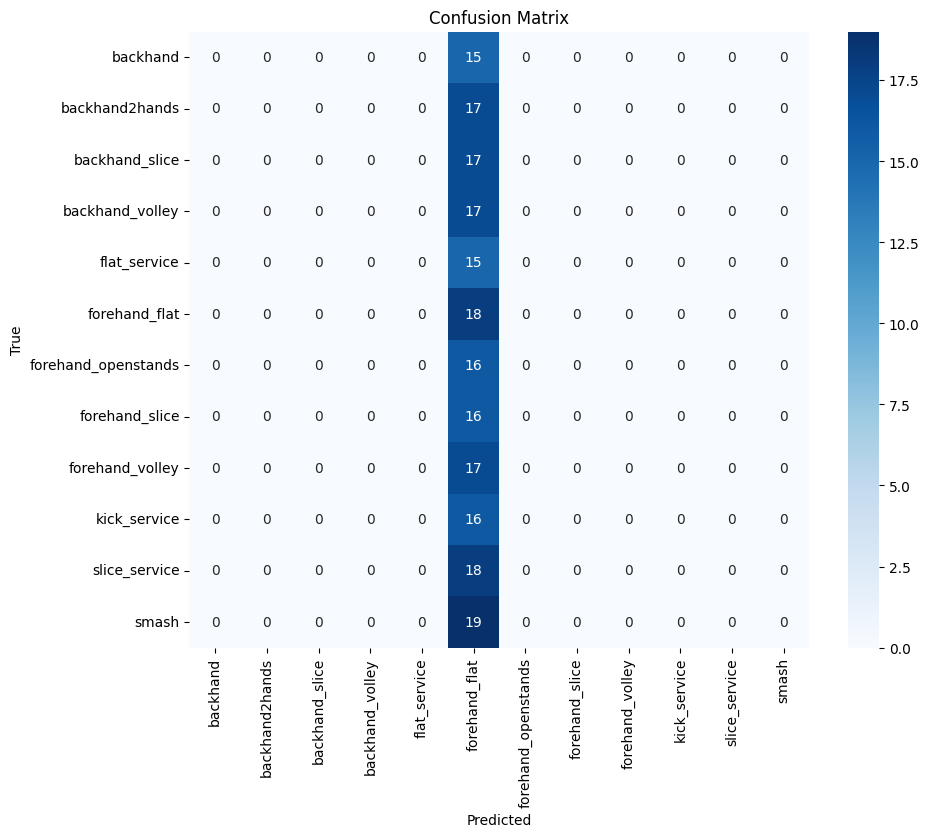

In [31]:
test_model(model, test_loader, label_map)
